# Standardising Australia Hazard Maps

The goal of this notebook is to develop and provide examples of mapping climate hazards for Australia so that data can be consistently presented.
Examples will include maps for Australia and for selected states or regions.

In [1]:
import datetime
datetime.datetime.today().date()

datetime.date(2024, 6, 7)

In [2]:
import sys
print(sys.executable)

/g/data/hh5/public/./apps/cms_conda/envs/analysis3-24.04/bin/python


In [3]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


In [4]:
# Plot Australian map without hazard

In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import seaborn as sns
import xarray as xr


# import colormap packages
import matplotlib.cm as cm
import cmaps
from matplotlib.colors import ListedColormap

# to plot cmaps
from pylab import *
from numpy import outer

from shapely.geometry import box


# Define the list of cities and their latitudes/longitudes
cities = ['Sydney', 'Melbourne', 'Brisbane', 'Perth', 'Adelaide', 'Canberra', 'Hobart', 'Darwin']
lats = [-33.865143, -37.813629, -27.469771, -31.953512, -34.928499,  -35.282001, -42.8821, -12.4637]
longs = [151.209900, 144.963165, 153.025124, 115.857048, 138.600739, 149.128998, 147.3272, 130.8444]


# crs = 'epsg:7844' #Australian centred
crs = 'epsg:3857'
xlim = (110,170)
ylim = (-45, -5)


# Create the DataFrame with the city data
data = {'cityname': cities,
        'lats': lats,
        'longs': longs,}
df = pd.DataFrame(data)
df.columns=['name', 'lat', 'lon']
df

,name,lat,lon
0,Sydney,-33.865143,151.209900
1,Melbourne,-37.813629,144.963165
2,Brisbane,-27.469771,153.025124
3,Perth,-31.953512,115.857048
4,Adelaide,-34.928499,138.600739
5,Canberra,-35.282001,149.128998
6,Hobart,-42.882100,147.327200
7,Darwin,-12.463700,130.844400


In [6]:
logo = image.imread("ACS_Logo_Blue_on_white_Stacked.png")

In [7]:
# These are a dictionary of suggested colormaps
# see here: https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml

cmap_dict = {"sst":cmaps.cmocean_tempo,
             "sst_anom": cmaps.cmocean_balance_r,
             "mhw_days": cm.YlOrRd,
             "mhw_intensity": cm.hot_r,
             "surface_pH":cm.YlGnBu,
             "surface_pH_1":cmaps.cmocean_phase,
             "surface_pH_2":cm.cool,
             "surface_aragonite_sat": cmaps.cmocean_delta,
             
             "tas":cm.Spectral_r,
             "tas_anom":cm.RdBu_r,
             "tas_anom_1":cm.seismic,
             "tas_deciles_bwr":cm.bwr,
             "EHF_days": cm.YlOrRd,
             "EHF_days_1": cm.YlOrBr,
             "EHF_duration":cm.hot_r,
             
             "AFDRS_category":ListedColormap(["white","green","orange", "red", "darkred"]),
             "ffdi_category":ListedColormap(["green", "blue", "yellow","orange", "red", "darkred"]),

             "pr":cm.YlGnBu,
             "pr_1":cmaps.cmocean_deep,
             "pr_days":cm.Blues,
             "pr_GMT_drywet": cmaps.GMT_drywet,
             "pr_rainbow_1":cmaps.prcp_1,
             "pr_rainbow_2":cmaps.prcp_2,
             "pr_rainbow_3":cmaps.prcp_3,         
             "pr_anom":cm.BrBG,
             "pr_anom_1":cmaps.cmocean_curl,
             "pr_anom_12lev":cmaps.precip_diff_12lev,
             
             "tc_days": cm.RdPu,
             "tc_intensity":cm.PuRd,
             "tc_days_anom":cm.PuOr,
             "tc_intensity_anom":cm.PiYG_r,

             "storm_count":cmaps.cmocean_dense,
             "storm_intensity":cmaps.cmocean_matter,
             "storm_count_anom":cmaps.cmocean_balance_r,
             "storm_intensity_anom": cmaps.cmocean_curl_r,
             
             "drought_severity": cm.RdYlGn_r,   
             "drought_duration":cmaps.hotres,
             
             "anom_BlueYellowRed":cmaps.BlueYellowRed,
             "anom":cmaps.BlueWhiteOrangeRed,
             "anom_b2r":cmaps.cmp_b2r,
             "anom_coolwarm":cmaps.MPL_coolwarm,
             "anom_deciles":cm.bwr,
             "anom_veg_1":cmaps.NEO_div_vegetation_a,          

             "BuGnRd":cmaps.temp1,

             "rh_19lev": cmaps.rh_19lev,
             "sunshine_9lev":cmaps.sunshine_9lev,
             "sunshine_diff_12lev":cmaps.sunshine_diff_12lev,
             "inferno":cm.inferno,
             "Oranges":cm.Oranges,
             "OrRd":cm.OrRd,
             "Greens": cm.Greens,

             "topo":cmaps.OceanLakeLandSnow,
             "gmt_relief":cmaps.GMT_relief,
            }

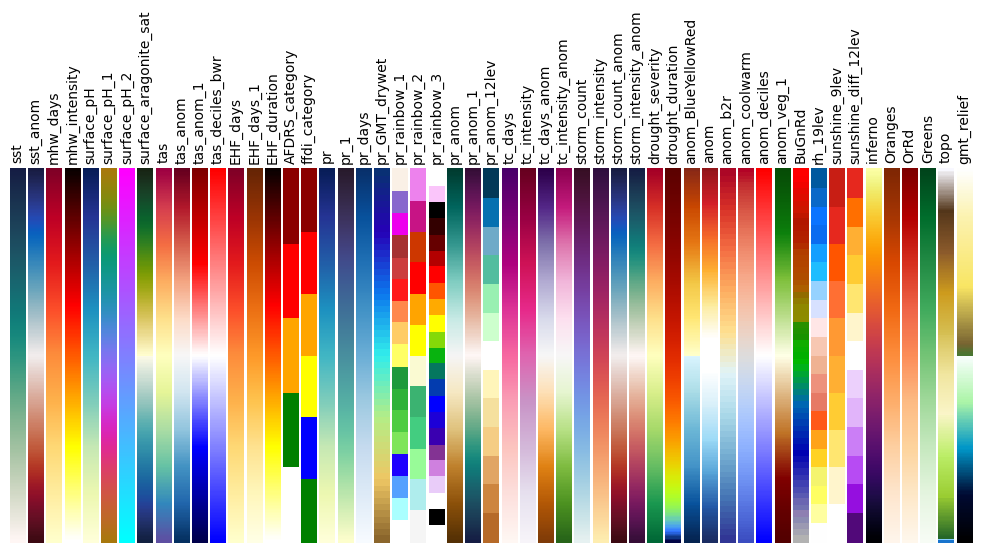

In [8]:
# show the colormaps in this dictionary
rc('text', usetex=False)
a=outer(arange(0,1,0.01),ones(10))
figure(figsize=(10,5))
subplots_adjust(top=0.8,bottom=0.05,left=0.01,right=0.99)
maps=[m for m in cmap_dict]
l=len(maps)+1
for i, m in enumerate(maps):
    subplot(1,l,i+1)
    axis("off")
    imshow(a,aspect='auto',cmap=cmap_dict[m],origin="lower")
    title(m,rotation=90,fontsize=10)
savefig("colormaps_aus_maps.png",dpi=100,facecolor='gray')

In [9]:
# This dictionary gives some sugeestions on the scale of the colour map to use for some variables. The scales are taken from cliamte maps on bom.gov.au/cliamte
tick_dict = {"pr_annual":  [0, 50, 100, 200, 300, 400, 600, 1000, 1500, 2000, 3000, 6000],
             "pr_6mon":    [0, 50, 100, 200, 300, 400, 600,  900, 1200, 1800, 2400, 6000],
             "pr_3mon":  [0, 10,  25,  50, 100, 200, 300,  400,  600,  800, 1200, 2500],
             "pr_mon" :  [0,  1,   5,  10,  25,  50, 100,  200,  300,  400,  600, 1200],
             "pr_days": [0, 2, 3, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 175],
             "pr_anom_mon": [-1000, -400, -200, -100, -50, -25, -10, 0, 10, 25, 50, 100, 200, 400, 1000],
             "pr_anom_3mon": [-2000, -600, -400, -200, -100, -50, -25, 0, 25, 50, 100, 200, 400, 600, 2000],
             "pr_anom_6mon": [-3000, -1200, -800, -400, -200, -100, -50, 0, 50, 100, 200, 400, 800, 1200, 3000],
             "pr_anom_ann": [-4000, -1800, -1200, -800, -400, -200, -100, 0, 100, 200, 400, 800, 1200, 1800, 4000],
             "pr_diff_mon": [-1000, -400, -200, -100, -50, -25, -10, 10, 25, 50, 100, 200, 400, 1000],
             "pr_diff_ann": [-3000, -1800, -1200, -800, -400, -200, -100, 100, 200, 400, 800, 1200, 1800, 3000],
             "frost_days": [0, 10, 20, 30, 40, 50, 75, 100, 150, 300],
             "frost_days_mon":[0, 2, 5, 10, 15, 20, 25, 31],
             "tas": np.arange(-9,52, 3),
             "tas_anom_day": np.arange(-14, 14.1, 2),
             "tas_anom_mon": np.arange(-7, 7.1, 1),
             "tas_anom_ann": np.arange(-3.5, 3.6, 0.5),
             "apparent_tas": np.arange(-6, 42, 3),
             "percent": np.arange(0,101,10),
             
            }            
             

In [10]:
# define a white mask for the area outside of Australian land

name = "australia"
australia = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')

# Define the CRS of the shapefile manually
australia.crs = crs

xlim = (110,170)
ylim = (-45, -5)

# map_total_bounds = (xlim[0], ylim[0], xlim[1], ylim[1])
map_total_bounds = australia.total_bounds


not_australia = gpd.GeoSeries(data = [box(*box(*map_total_bounds).buffer(10).bounds).difference(australia["geometry"].values[0])],
                              crs=crs,)


In [51]:
def plot_aus_shapefiles(name =  "aus_states_territories",
                        gdf = None,
                        data = None,
                        facecolor = None, 
                        edgecolor = "black",
                        figsize = (8,6),
                        title = None,
                        crs = crs,
                        area_linewidth = 0.3,
                        xlim = (110,170),
                        ylim = (-45, -5),
                        cmap = cm.Greens,
                        varname = None,
                        cbar_extent = "both",
                        ticks = None, 
                        cbar_label = "",
                        date_range = "",
                        mask_not_australia = True,
                        issued_date = datetime.datetime.today().date().strftime('%d/%m/%Y'),
                        dataset_name = None,
                        baseline = None,
                        label_states = False,
                        contourf = True,
                        contour = True,
                        select_area = None,
                        land_shadow = False,
                       ):
    """This function takes a name of a Australian shapefile collection for data in /g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/ 
    and plots a map of Australia with the shape outlines. The map is saved as a png in your working directory.
    This function returns fig and ax.
    gdf expects a geopandas.GeoDataFrame, if none, then will try to read from f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp'
    facecolor reccommendations include "white", "lightgrey", "none"
    edgecolor reccommendations include "black" and "white"
    """
    if gdf is None:
        try:
            gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')
        except:
            print(f"Could not read /g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp")
        
    # Define the CRS of the shapefile manually
    gdf.crs = crs

    # Set up the plot
    # sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=figsize, zorder=1, layout="constrained")
    
    if data is not None:
        if ticks is None:
            norm=None
        else:    
            norm = mpl.colors.BoundaryNorm(ticks, cmap.N)
        # plot the hazard data
        if contourf:
            plt.contourf(data.lon, data.lat, data, cmap = cmap, norm=norm, levels=ticks, zorder=2)
        else:
            plt.pcolormesh(data.lon, data.lat, data, cmap = cmap, norm=norm, zorder=2)
        if mask_not_australia:
            # outside the shape, fill white
            not_australia.plot(ax=ax, facecolor="white", linewidth=0, zorder=5)    
        cbar = plt.colorbar(extend = cbar_extent, cax=ax.inset_axes([0.85,0.2, 0.03, 0.6]), ticks=ticks, norm=norm,)
        cbar.ax.set_title(cbar_label, zorder=8, y=1.1, loc="left")
        if contour:
            cont = plt.contour(data.lon, data.lat, data, colors="grey", norm=norm, levels=ticks, linewidths=0.2, zorder=3)
            cbar.add_lines(cont)
        
        facecolor = "none"

    if label_states and name=="aus_states_territories":
        # label the states with their name in the centre of the state
        states = ["WA", "NT", "SA", "QLD", "NSW", "VIC", "TAS"]
        lats = [-26.06, -19.7, -29.0, -24.2, -32.3, -37.1, -42.4]
        lons = [119.9, 133,  133, 143.6, 143.7, 142.0, 145.3]
        for lon, lat, state in zip(lons, lats, states):
            plt.text(lon, lat, state, size=12, zorder=10)
    
    gdf.plot(ax=ax,
             facecolor=facecolor,
             edgecolor=edgecolor, 
             linewidth=area_linewidth,
             zorder=4
            )

    # if select a specific area
    if select_area is None:
        plt.xlim(xlim)
        plt.ylim(ylim)
    else:
        assert isinstance(select_area, list), "select_area must be a list"
        # select state
        area =gdf.loc[gdf.STE_NAME21.isin(select_area)] 
        map_total_bounds = area.total_bounds
        minx, miny, maxx, maxy = map_total_bounds
        mid_x = (minx+maxx)/2
        mid_y = (miny+maxy)/2
        max_range = np.max([(maxy-miny), (maxx-minx)])
        buffer=0.1*max_range
        
        not_area =  gpd.GeoSeries(data = [box(*box(*map_total_bounds).buffer(10*buffer).bounds).difference(area.dissolve()["geometry"].values[0])],
                                      crs=crs, )

        # mask outside selected area
        if land_shadow:
            # show land as light grey
            not_area.plot(ax=ax, facecolor="lightgrey", linewidth=0, zorder = 4)
        else:
            # mask white
            not_area.plot(ax=ax, facecolor="white", linewidth=0, zorder = 4)
               
        plt.xlim(mid_x - 0.6*max_range, mid_x + 0.8*max_range)
        plt.ylim(mid_y - 0.7*max_range, mid_y + 0.7*max_range)      
        
    
    # Set the plot title and axis labels
    if title is None:
        title = name

    ax = plt.gca()
    ax.text(0.15,0.1,f"{title}\n{date_range}",
            horizontalalignment='left',
            transform=ax.transAxes,
            zorder=10)


    # print base period inside bottom left corner
    ax.text(x=0.01, y=0.01, s= f"Base period: {baseline}", fontsize=6, transform=ax.transAxes, zorder = 10)
    # print copyright outside bottom left corner
    ax.text(x=0.01, y=-0.03, s= f"(C) Commonwealth of Australia {datetime.datetime.now().year}, Australian Climate Service", fontsize=6, transform=ax.transAxes, zorder = 10)
    # print data source inside bottom right
    ax.text(x=0.99, y=0.01, s= f"Dataset: {dataset_name}", fontsize=6, transform=ax.transAxes, horizontalalignment="right", zorder = 10)
    ax.text(x=0.99, y=-0.03, s= f"Issued: {issued_date}", fontsize=6, transform=ax.transAxes, horizontalalignment="right", zorder = 10)

    # remove any lat lon labels and ticks
    plt.xlabel('')
    plt.ylabel('')
    plt.tick_params(axis="both", which = "both", bottom =False, left=False, labelbottom = False, labelleft=False)

    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth(2)
    
    # Place logo in top left
    ax.imshow(logo, extent=(0.0, 0.4*(figsize[1]/figsize[0]), 0.85, 1.0),  transform=ax.transAxes, zorder = 10) 
    
    fig.set_figheight(figsize[1])
    fig.set_figwidth(figsize[0])

    plt.savefig(f"{title}.png",)
    return fig, ax

In [12]:
# write a dictionary of the shapefile geopandas dataframes. These will be used for state boundaries, LGAs, NR
shape_files = [ "aus_local_gov", "aus_states_territories", "australia", "nrm_regions", "river_regions"]

gdf_dict = {}
for name in shape_files:
    gdf_dict.update({name: gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')})
gdf_dict.update({"broadacre_regions" : gpd.read_file('/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/broadacre_regions/aagis_asgs16v1_g5a.shp')})

    

In [13]:
# find the name of the first column containing the substring "name" else return the first column
for key in gdf_dict.keys():
    try:
        print([name for name in gdf_dict[key].columns if 'NAME' in name.upper()][0])
    except:
        print(gdf_dict[key].columns[0])

LGA_NAME22
STE_NAME21
AUS_NAME21
SubClusNm
RivRegName
name


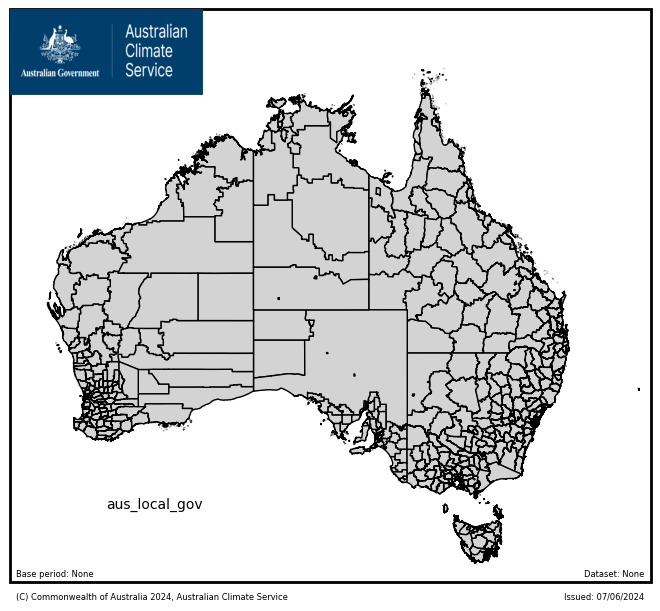

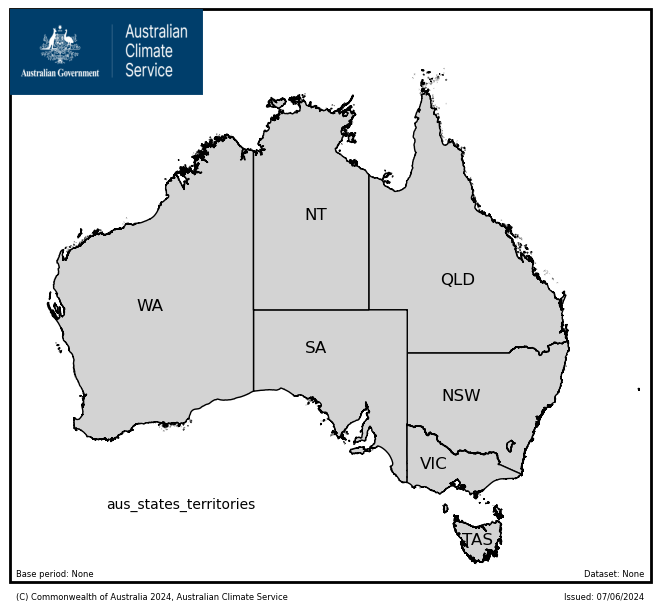

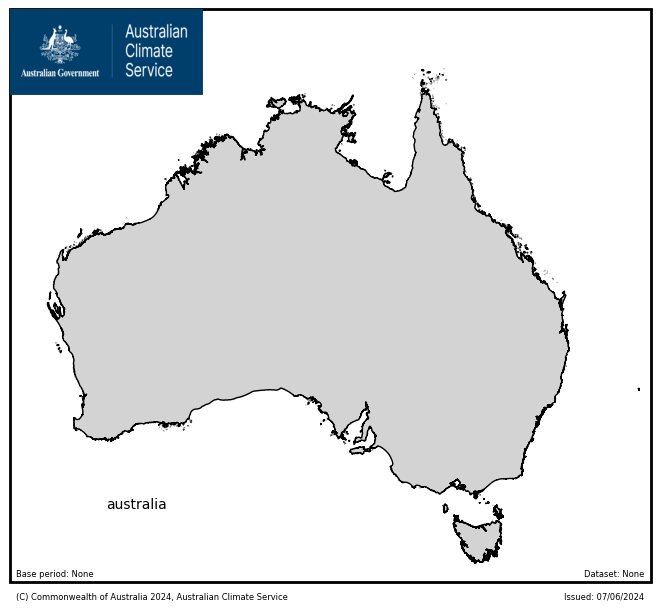

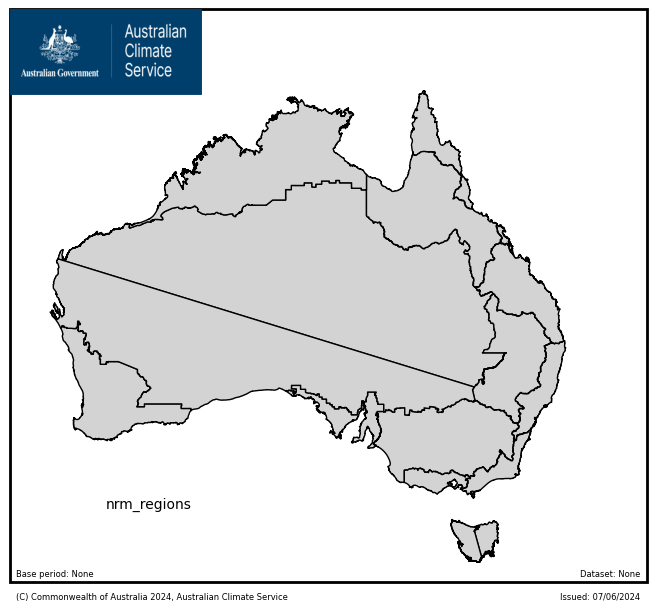

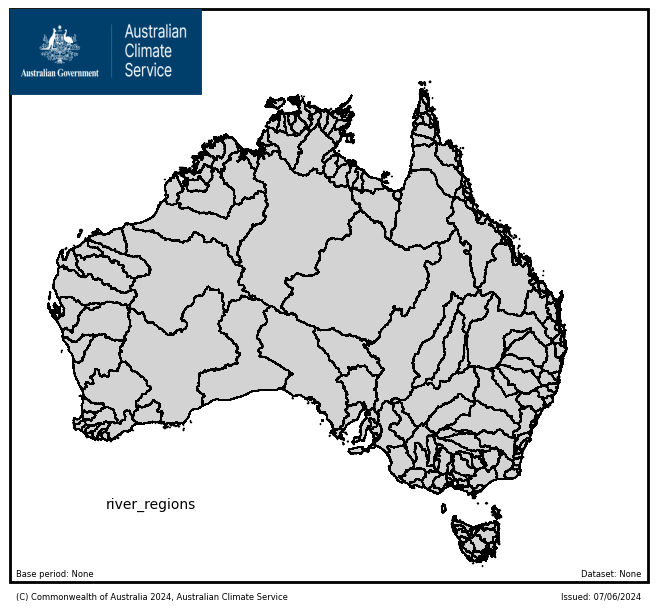

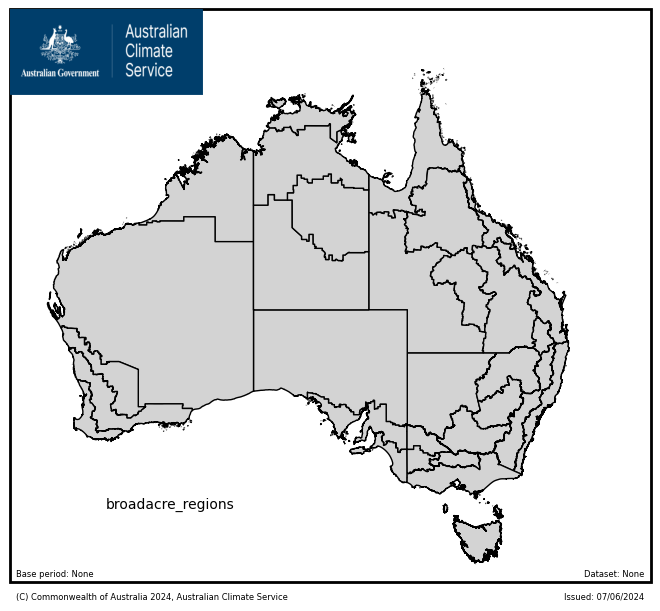

In [32]:
facecolor = "lightgrey"# "none"
edgecolor = "black" # "white"

xlim = (110,160)
ylim = (-45, -5)

for name in gdf_dict.keys():
    plot_aus_shapefiles(name = name,
                        gdf = gdf_dict[name],
                        facecolor = facecolor, 
                        edgecolor = edgecolor,
                        xlim = xlim,
                        ylim = ylim,
                        label_states = True);


In [15]:
# Plot Australian map

In [16]:
# Plot Australian map with states

In [17]:
# plot one state

In [18]:
# load some data
pr_data = xr.open_dataset("/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/bias-adjustment-input/AGCD-05i/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/pr/pr_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_day_201501-201512.nc")
pr_data

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 365, lat: 691, lon: 886, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2015-01-01T12:00:00 ... 2015-12-31T1...
  * lat        (lat) float64 6kB -44.5 -44.45 -44.4 ... -10.1 -10.05 -10.0
  * lon        (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
Dimensions without coordinates: bnds
Data variables:
    pr         (time, lat, lon) float64 2GB ...
    lat_bnds   (lat, bnds) float64 11kB ...
    lon_bnds   (lon, bnds) float64 14kB ...
    time_bnds  (time, bnds) datetime64[ns] 6kB ...
Attributes: (12/47)
    Conventions:               CF-1.10, ACDD-1.3
    activity_id:               DD
    title:                     Pre-processed model output in preparation for ...
    source:                    ssp370 run using CSIRO-ARCCSS ACCESS-CM2 r4i1p...
    source_type:               ARCM
    project:                   BARPA
    ...                        ...
    acknowledgement:           The production of BARPA was supported with fun...
    driving_experiment:        CSIRO-ARCCSS ACCESS-CM2; ssp370; r4i1p1f1
    driving_source_id:         ACCESS-CM2
    input_tracking_id:         62d5d07a-7da8-4bab-b5dc-ba08231c073d
    history:                   Thu Apr 11 17:20:40 2024: ncatted -O -a least_...
    NCO:                       netCDF Operators version 5.0.5 (Homepage = htt...

In [19]:
ds_pr = pr_data.sum(dim="time").pr


(<Figure size 800x600 with 1 Axes>, <Axes: >)

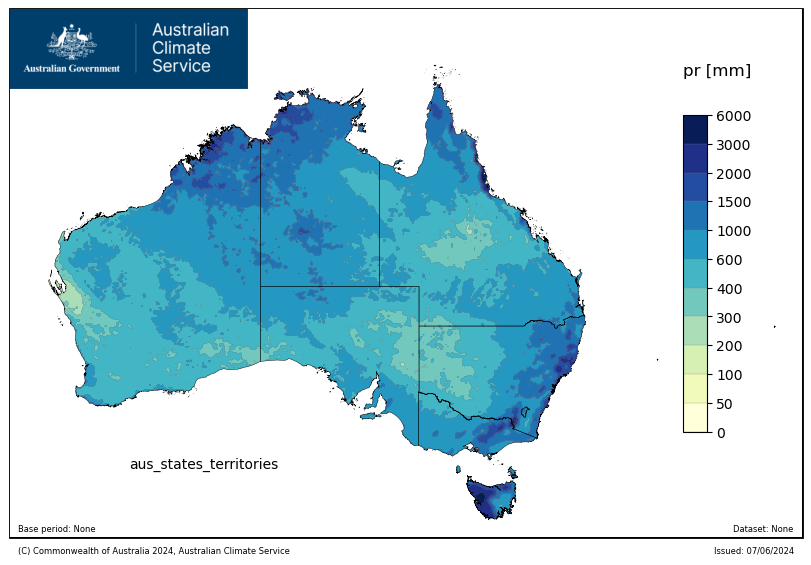

In [30]:
plot_aus_shapefiles(data = ds_pr,
                    gdf = gdf_dict['aus_states_territories'],
                   cmap=cmap_dict["pr"],
                   ticks=tick_dict['pr_annual'],
                   cbar_extent="max",
                   cbar_label="pr [mm]")

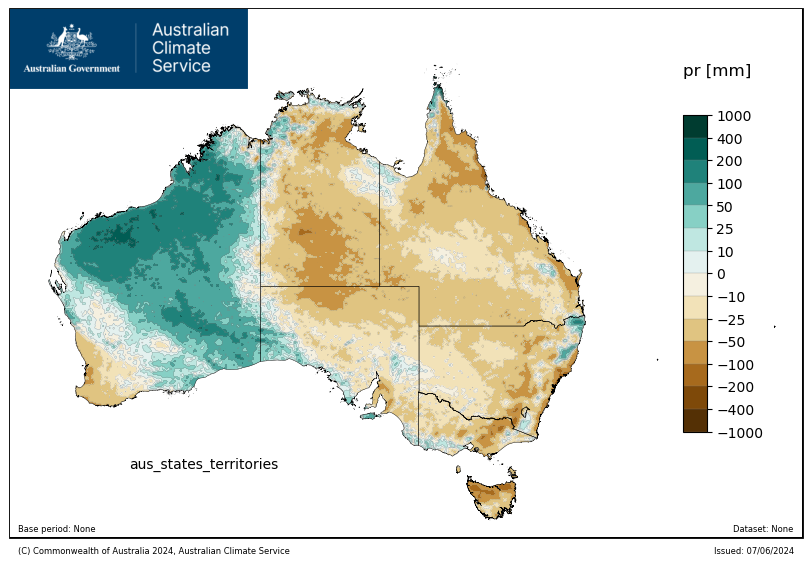

In [21]:
# make a DataAray with an anomaly
ds_pr_jan = pr_data.sel(time = pr_data.time.dt.month==1).sum(dim="time").pr
ds_pr_anom = ds_pr_jan-ds_pr/12


plot_aus_shapefiles(data = ds_pr_anom,
                    gdf = gdf_dict['aus_states_territories'],
                   cmap=cmap_dict["pr_anom"],
                   ticks=tick_dict['pr_anom_mon'],
                   cbar_label="pr [mm]");

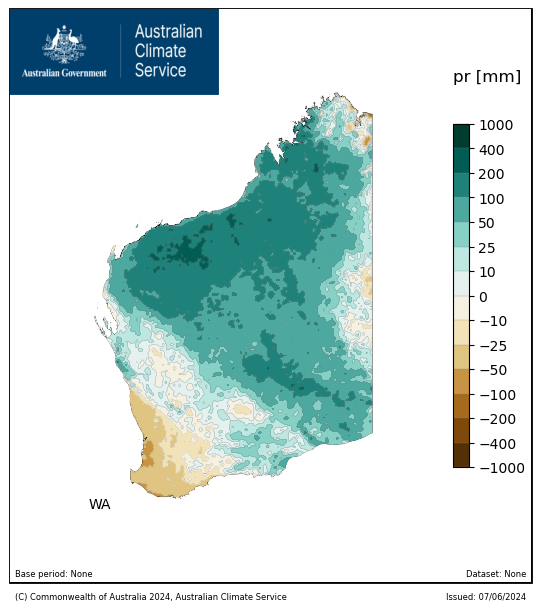

In [43]:

plot_aus_shapefiles(data = ds_pr_anom,
                    gdf = gdf_dict['aus_states_territories'],
                   cmap=cmap_dict["pr_anom"],
                   ticks=tick_dict['pr_anom_mon'],
                   cbar_label="pr [mm]",
                   select_area=["Western Australia"],
                   figsize=(6,6),
                   title="WA");

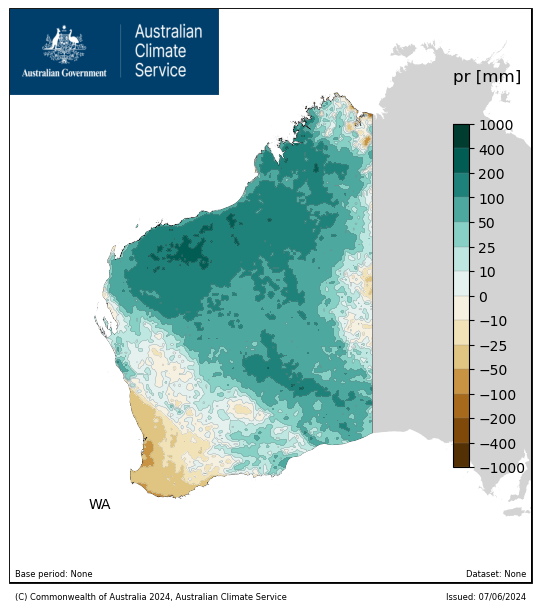

In [52]:

plot_aus_shapefiles(data = ds_pr_anom,
                    gdf = gdf_dict['aus_states_territories'],
                   cmap=cmap_dict["pr_anom"],
                   ticks=tick_dict['pr_anom_mon'],
                   cbar_label="pr [mm]",
                   select_area=["Western Australia"],
                   figsize=(6,6),
                   title="WA",
                   land_shadow=True);

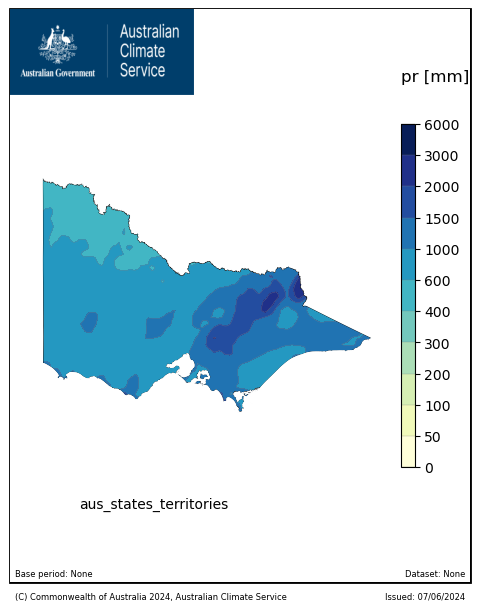

In [53]:
plot_aus_shapefiles(data = ds_pr,
                    gdf = gdf_dict['aus_states_territories'],
                   cmap=cmap_dict["pr"],
                   ticks=tick_dict['pr_annual'],
                   cbar_extent="max",
                   select_area=["Victoria"],
                   figsize=(6,6),
                   cbar_label="pr [mm]");

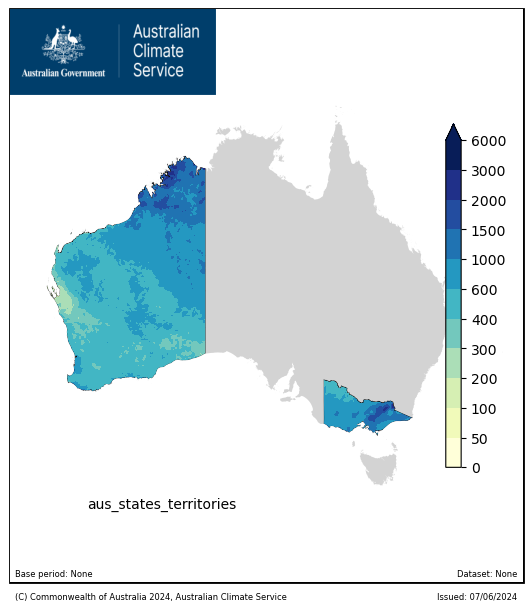

In [55]:
fig, ax = plot_aus_shapefiles(data = ds_pr,
                              gdf = gdf_dict['aus_states_territories'],
                              cmap=cmap_dict["pr"],
                              ticks=tick_dict['pr_annual'],
                              cbar_extent="max",
                              select_area=["Victoria", "Western Australia"],
                              contourf=False,
                              figsize=(6,6),
                              contour=False,
                             land_shadow=True)


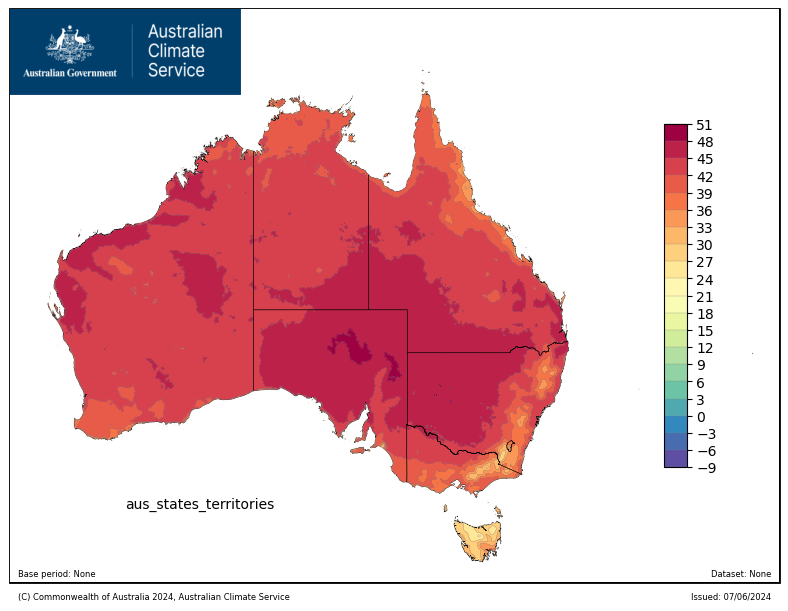

In [56]:
tas_data = xr.open_dataset("/g/data/ia39/australian-climate-service/test-data/CORDEX-CMIP6/bias-adjustment-input/AGCD-05i/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/tasmax/tasmax_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_day_201501-201512.nc")
ds_tas = tas_data.tasmax.max(dim="time")

plot_aus_shapefiles(data = ds_tas,
                    gdf = gdf_dict['aus_states_territories'],
                   cmap=cmap_dict["tas"],
                   ticks=tick_dict['tas'],
                   );

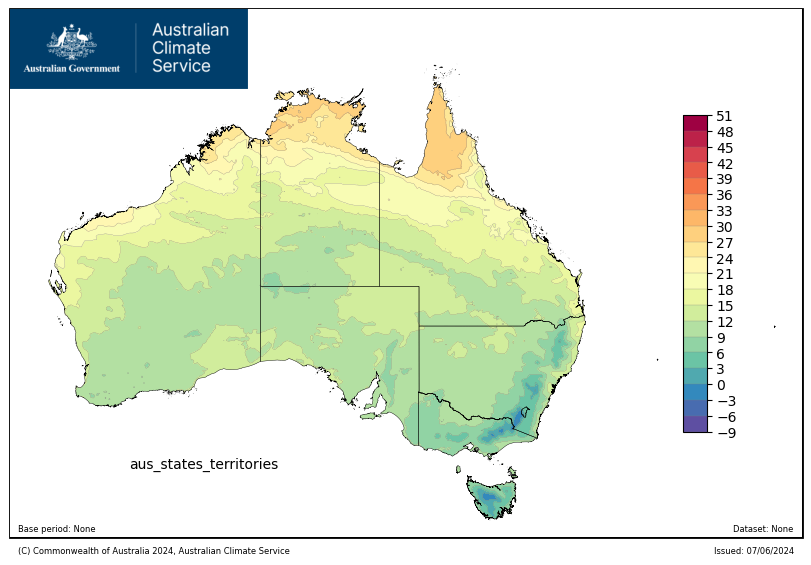

In [28]:
ds_tas = tas_data.tasmax.min(dim="time")

plot_aus_shapefiles(data = ds_tas,
                    gdf = gdf_dict['aus_states_territories'],
                   cmap=cmap_dict["tas"],
                   ticks=tick_dict['tas'],
                   contour=True);

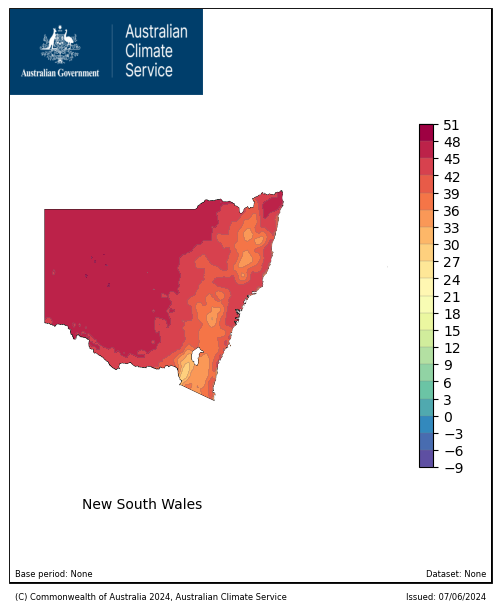

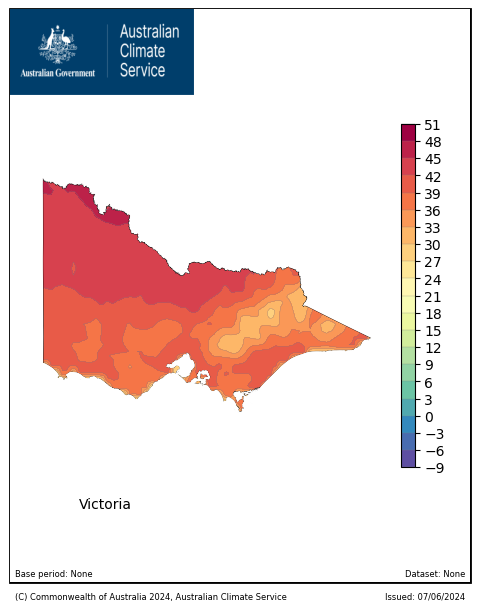

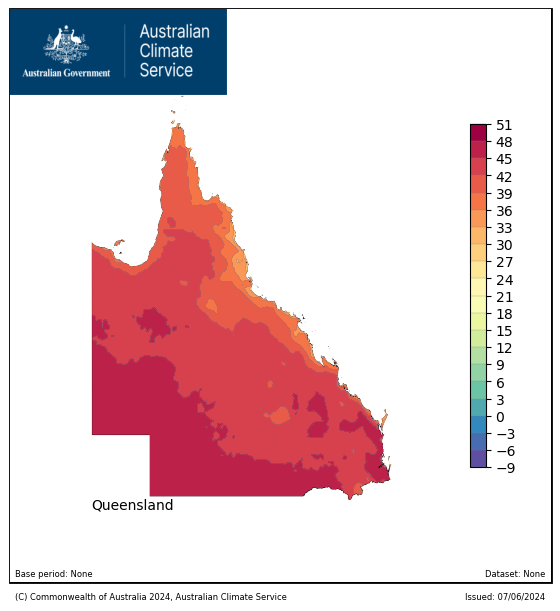

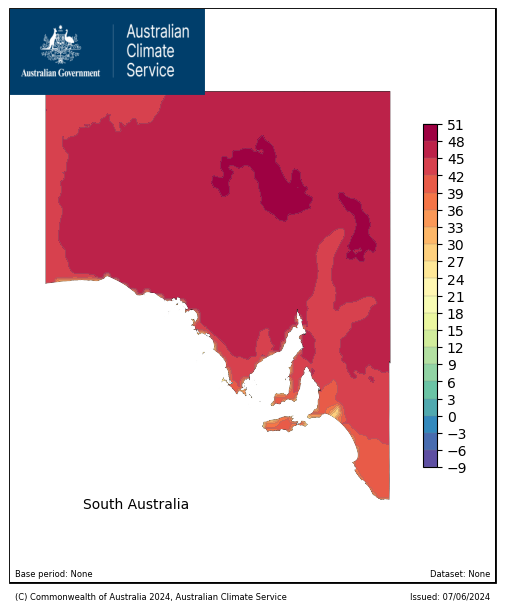

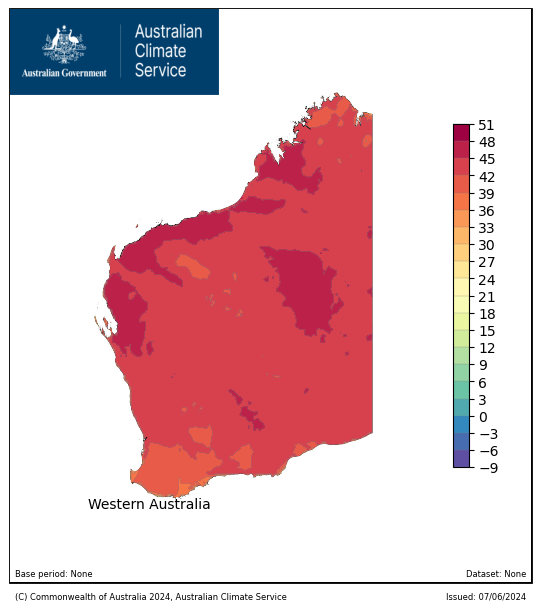

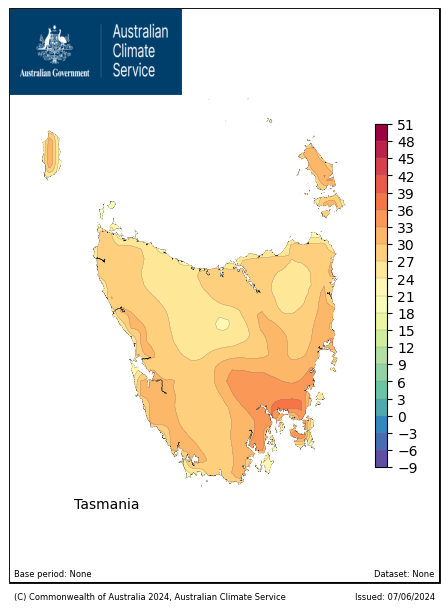

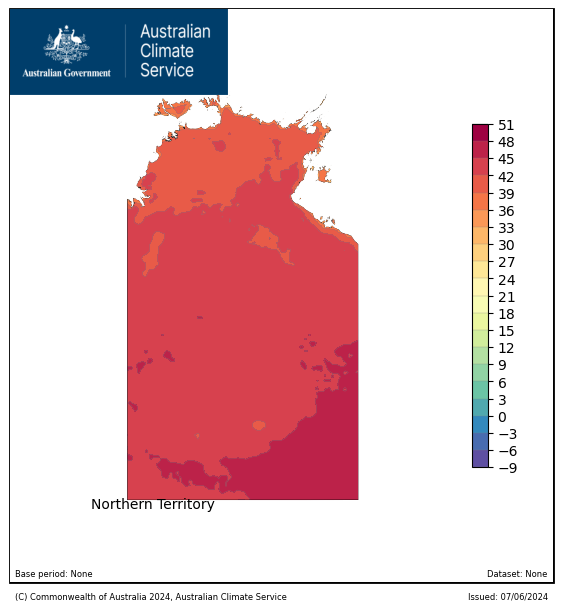

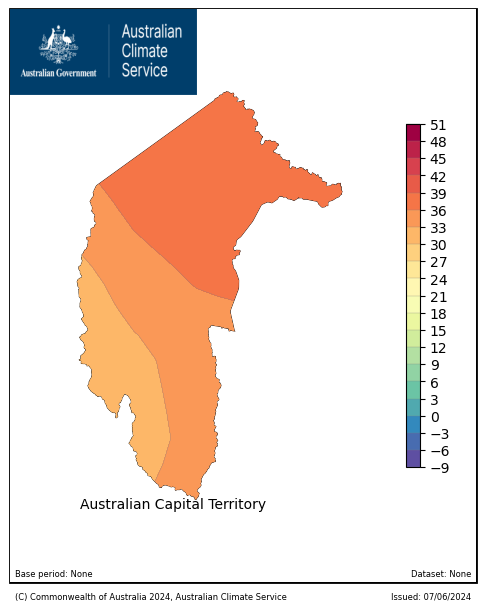

In [59]:
name = "aus_states_territories" 
gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/{name}/{name}.shp')

for state in list(gdf.STE_NAME21)[:-1]:
    plot_aus_shapefiles(data = ds_tas,
                        figsize=(6,6),
                        gdf = gdf_dict['aus_states_territories'],
                       cmap=cmap_dict["tas"],
                       ticks=tick_dict['tas'],
                       contour=True,
                       select_area=[state],
                       title=state);

To do:
- test with different data
- fix shape of plots
- fix shape of logo 
- nealty present examples
- select multiple areas (not states)


notebook:
import packages
load data for boundaries 
define cmaps
define dictionaries of handy scales etc
define the function

example 1:
 - Australia blank map only

Example 2:
 - State lines on Australia, with temperature data

Example 3:
 - Vic only, with rainfall data

